Start this first
```bash
$ litex_server uart /dev/ttyUSB0 1152000
# or alternatively
$ litex_server udp 192.168.1.50 1234
```

In [153]:
%pylab notebook
from litex.soc.tools.remote import RemoteClient
from struct import pack, unpack
import time
from scipy.signal import *

Populating the interactive namespace from numpy and matplotlib


In [154]:
for i in range(32):
    try:
        r = RemoteClient(csr_csv="build/csr.csv", debug=False, port=1234 + i)
        r.open()
        print("Connected to Port", 1234 + i)
        break
    except ConnectionRefusedError:
        pass

def getId():
    s = ""
    for i in range(64):
        temp = r.read(r.bases.identifier_mem + i * 4)
        if temp == 0:
            break
        s += chr(temp & 0xFF)
    return s
getId()

Connected to Port 1234


'LTC2175 demonstrator 2019-04-17 00:46:36'

# Setup SPI

In [328]:
# config bits
OFFLINE      = 0  # all pins high-z (reset=1)
CS_POLARITY  = 3  # active level of chip select (reset=0)
CLK_POLARITY = 4  # idle level of clk (reset=0)
CLK_PHASE    = 5  # first edge after cs assertion to sample data on (reset=0)
LSB_FIRST    = 6  # LSB is the first bit on the wire (reset=0)
HALF_DUPLEX  = 7  # 3-wire SPI, in/out on mosi (reset=0)
DIV_READ     = 16 # SPI read clk divider (reset=0)
DIV_WRITE    = 24 # f_clk / f_spi_write == div_write + 2
# xfer bits
CS_MASK      =  0 # Active high bit mask of chip selects to assert (reset=0)
WRITE_LENGTH = 16 # How many bits to write and ...
READ_LENGTH  = 24 # when to switch over in half duplex mode

r.regs.spi_config.write((0xFF << DIV_WRITE) | (0xFF << DIV_READ))

# 16 bit write transfer (includes read as is 4 wire)
r.regs.spi_xfer.write((0 << READ_LENGTH) | (0x10 << WRITE_LENGTH) | (0xFFFF << CS_MASK))

def set_ltc_reg(adr, val):
    word = (0 << 15) | ((adr & 0x7F) << 8) | (val & 0xFF)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)

def get_ltc_reg(adr):
    word = (1 << 15) | ((adr & 0x7F) << 8)
    word <<= 16
    r.regs.spi_mosi_data.write(word)
    r.regs.spi_start.write(1)
    return r.regs.spi_miso_data.read() & 0xFF

def setTp(tpValue):
    set_ltc_reg(3, (1<<7) | tpValue >> 8)   # Test pattern on + value MSB
    set_ltc_reg(4, tpValue & 0xFF)          # Test pattern value LSB
    
def myzip(*vals):
    """
    interleave elements in a flattened list

    >>> myzip([1,2,3], ['a', 'b', 'c'])
    [1, 'a', 2, 'b', 3, 'c']
    """
    return [i for t in zip(*vals) for i in t]

def getInt32(I):
    """ 
    recover sign from twos complement integer
    >>> getInt32(0xFFFFFFFF)
    -1
    """
    return unpack("i", pack("I", I))[0]

# Dump LTC2175 registers

In [329]:
for i in range(5):
    print("{:2x}: {:02x}".format(i, get_ltc_reg(i)))

 0: 00
 1: 00
 2: 00
 3: 00
 4: 00


In [330]:
set_ltc_reg(0, 0x80)   # Software reset

In [ ]:
set_ltc_reg(1, 0x10)   # Sleep mode

In [ ]:
set_ltc_reg(1, 0x00)   # Waky waky

# Measure sample clock frequency [Hz]

In [331]:
r.regs.lvds_f_sample_value.read()

120000000

# Read and align clock data

In [332]:
rVal = r.regs.lvds_clk_peek.read()
print("0x{0:02X} 0b{0:08b}".format(rVal))

0x0F 0b00001111


do a bitslip until we get 0x0F

In [167]:
r.regs.lvds_bitslip_csr.write(1)

# Map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [333]:
for i in range(14):
    tpValue = 1 << i
    setTp(tpValue)
    rVal = r.regs.lvds_data_peek.read()
    print("{:016b} {:016b}".format(tpValue, rVal))

0000000000000001 0000000000000100
0000000000000010 0000000000001000
0000000000000100 0000000000010000
0000000000001000 0000000000100000
0000000000010000 0000000001000000
0000000000100000 0000000010000000
0000000001000000 0000000100000000
0000000010000000 0000001000000000
0000000100000000 0000010000000000
0000001000000000 0000100000000000
0000010000000000 0001000000000000
0000100000000000 0010000000000000
0001000000000000 0100000000000000
0010000000000000 1000000000000000


# Read ADC sample

In [334]:
set_ltc_reg(3, 0)   # Test pattern off
set_ltc_reg(1, 0)   # Randomizer off

In [341]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# Decode offset binary mode
print(rVal - (1 << 11))

0x7fd 0b011111111101
-3


# Read randomized ADC sample

In [ ]:
set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read phase detectors
Make sure to disable the test-pattern to get transitions on all LVDS lanes

In [370]:
integr = 2**10
r.regs.lvds_pd_period_csr.write(integr)
r.regs.lvds_pd_period_csr.read()

1024

In [371]:
def printPd():
    val0 = getInt32(r.regs.lvds_pd_phase_0.read()) / integr
    val1 = getInt32(r.regs.lvds_pd_phase_1.read()) / integr
    print("\r{:0.3f}  {:0.3f}          ".format(val0, val1), end="")
    return val0, val1

In [375]:
val0, val1 = printPd()

0.156  0.176          

# Control Idelays manually

In [290]:
# Choose channel
r.regs.lvds_idelay_mux.write(0)
r.regs.lvds_idelay_mux.read()

0

In [322]:
r.regs.lvds_idelay_inc.write(0)   # Increment delay

In [299]:
r.regs.lvds_idelay_dec.write(0)   # Decrement delay

In [323]:
printPd()

-0.718  0.000          

(-0.7183411121368408, 0.0)

# Control Idelays automatically
Let the gateware step up / down the idelays and monitor the phase detector values

In [324]:
# Enable / disable auto phase tracking mode
r.regs.lvds_idelay_auto.write(1)
# Print phase
p0s = []
p1s = []
while True:
    val0, val1 = printPd()
    p0s.append(val0)
    p1s.append(val1)
    time.sleep(0.1)

-0.647  0.000          

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


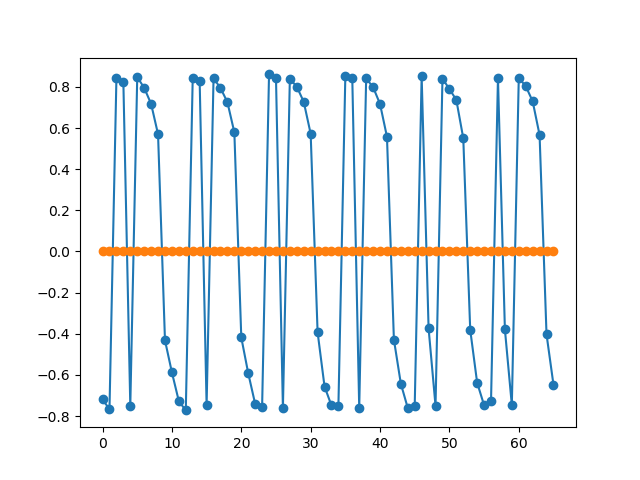

In [325]:
r.regs.lvds_idelay_auto.write(0)
close("all")
plot(p0s, "-o")
plot(p1s, "-o")

# Scope plot

<IPython.core.display.Javascript object>


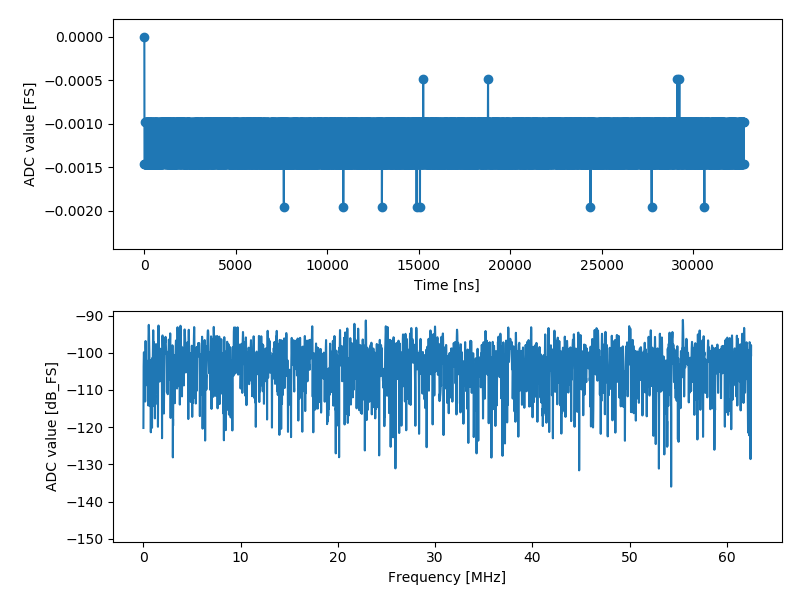

In [381]:
from matplotlib.animation import FuncAnimation

def setTriggerLevel(l):
    """ -1 < l < 1 """
    tl = int((l + 1) * (1 << 15))
    print(tl)
    r.regs.acq_trig_level.write(tl)
    
def getSamples(N=None):
    """ why doesn't RemoteClient take care of chunking for me ??? """
    if N is None:
        N = r.mems.sample.size
    o = r.mems.sample.base
    r.regs.acq_trig_csr.write(0)
    samples = []
    while N:
        temp = r.read(o, min(255, N))
        o += len(temp) * 4  # in bytes!
        N -= len(temp)
        samples.append(temp)
    samples = hstack(samples)
    return samples / (1<<15) - 1 

def ani(i, N):
    yVect = getSamples(N)
    f, Pxx = periodogram(yVect, fs, window='hanning', scaling='spectrum', nfft=N*4)
    lt.set_ydata(yVect)
    lf.set_ydata(10*log10(Pxx) + 3)

close("all")
N = 4096
fs = 125e6
set_ltc_reg(3, 0)   # Test pattern off
set_ltc_reg(1, 0)   # Randomizer off
xVect = linspace(0, N / fs, N, endpoint=False)
yVect = getSamples(N)
fig, axs = subplots(2, 1, figsize=(8, 6), squeeze=True)
lt, = axs[0].plot(xVect * 1e9, yVect, "-o")
f, Pxx = periodogram(yVect, fs, window='hanning', scaling='spectrum', nfft=N*4)
lf, = axs[1].plot(f / 1e6, 10*log10(Pxx) + 3)
axs[0].set_xlabel("Time [ns]")
axs[1].set_xlabel("Frequency [MHz]")
axs[0].set_ylabel("ADC value [FS]")
axs[1].set_ylabel("ADC value [dB_FS]")
fig.tight_layout()
FuncAnimation(fig, ani, interval=500, fargs=(N,))

In [383]:
r.regs.lvds_idelay_auto.write(0)

In [384]:
setTriggerLevel(0.1)

36044


In [ ]:
dat = []
for i in range(32):
    dat.append(getSamples(2**12-1))
    print("*", end="", flush=True)
dat = vstack(dat)

In [ ]:
savez_compressed("550MHz_0dBm.npz", dat=dat)

In [151]:
def getNyquist(f, fs):
    f_n = f / fs
    f_fract = f_n % 1
    if f_fract <= 0.5:
        return f_fract * fs
    else:
        return (1 - f_fract) * fs

In [152]:
ffs = 120
getNyquist(499.6, ffs) / ffs

0.1633333333333331

In [47]:
getNyquist(500, 1200/10)

20.000000000000036

In [ ]:
close("all")
for fName in ["fullscale", "550MHz_15dBm.npz", "550MHz_10dBm.npz", "550MHz_5dBm.npz", "550MHz_0dBm.npz"]:
    if fName == "fullscale":
        continue
        d = sin(arange(4095))
        dat = vstack([d, d])
    else:
        dat = load(fName)["dat"]
    f, Pxx = periodogram(dat, fs, window='hanning', scaling='spectrum', nfft=2**15)
    plot(f / 1e6, 10*log10(mean(Pxx, 0)) + 3, label=fName)
legend()
xlabel("Frequency [MHz]")
ylabel("[db_fs]")

In [ ]:
5 * fs + 17e6

In [ ]:
r.close()